### **Digital Bookshelf: Throwing more out-of-the-box OCR systems at my problem**

After [limited success](https://github.com/davisrbr/bookRecognition/blob/master/notebooks/Traditional_Image_Processing.ipynb) with my previous attempt with Google's Tesseract OCR, I've decided to throw more out-of-the-box optical character recognition systems at the pre-delineated books and see which performs best. The biggest takeaway from this notebook is that pretty good OCR systems are now abundantly available.  

### First attempt: Easy OCR 
I'm first going to try [Jaided AI's Easy OCR](https://github.com/JaidedAI/EasyOCR). 

_Note: the model did not download for me, I had to grab the .pth file from [here](https://drive.google.com/file/d/1tdItXPoFFeKBtkxb9HBYdBGo-SyMg1m0/view)_.

In [1]:
# imports, path management
import matplotlib.pyplot as plt
import sys
import os 


sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

I ended up pulling the matplotlib plots and pre-processing (i.e. deskewing, gray scaling, etc.) [into the function](https://github.com/davisrbr/bookRecognition/blob/master/utils) `plot_ocr`.

In [2]:
from plot_utils import plot_ocr
import easyocr


reader = easyocr.Reader(['en'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


CPU times: user 4min 32s, sys: 9.35 s, total: 4min 42s
Wall time: 3min 11s


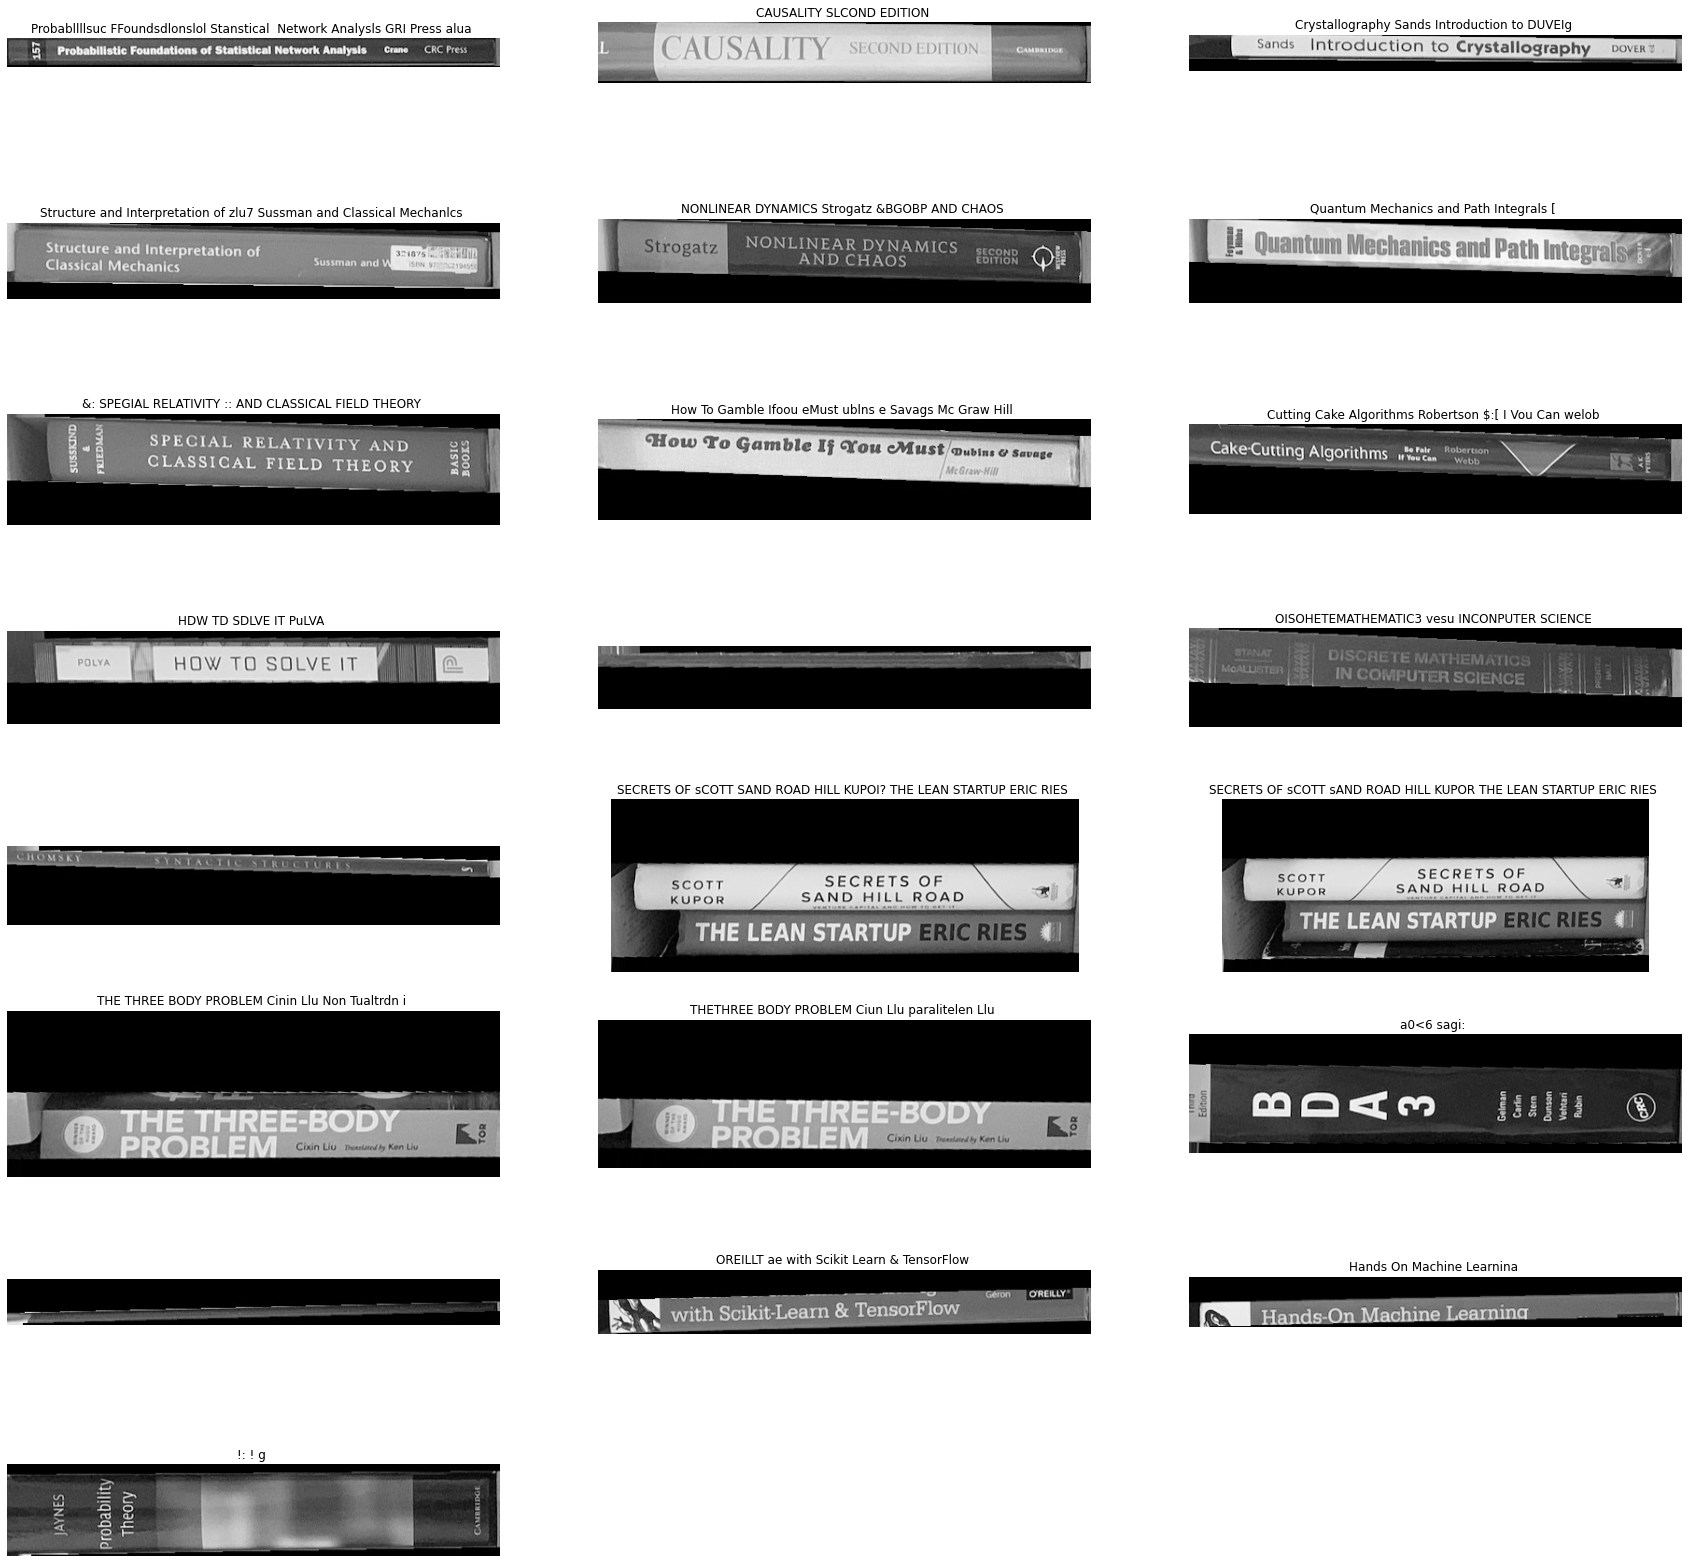

In [3]:
%%time
figure, axes = plot_ocr('../filteredbooks_CV/', 
                        reader.readtext,
                        gray=True,
                        deskew=True)

This performance was significantly better than my [last attempt!](https://github.com/davisrbr/bookRecognition/blob/master/notebooks/Traditional_Image_Processing.ipynb) The backbone algorithm is called [CRAFT, from this paper](https://arxiv.org/pdf/1904.01941.pdf). CRAFT uses character level detection. The paper uses a relatively clever approach where they do weakly-supervised learning for individual characters leveraged from datasets with word-level annotations. 

With some high powered regex and better delineation of the books, I suspect I will be able to identify all of these book titles + authors from a database. 

### Second attempt: keras-ocr
I'm still not happy with the speed (although I could make increase speed by ONNX-ing the PyTorch model behind Easy OCR. Or still, I could run it on a GPU). The [keras-ocr library](https://github.com/faustomorales/keras-ocr) also implements CRAFT in Keras/TensorFlow. I try out the performance of this library next.

In [4]:
import keras_ocr
import os
import matplotlib.pyplot as plt
from plot_utils import drawAnnotations
import tensorflow as tf
import logging


tf.get_logger().setLevel(logging.ERROR)

pipeline = keras_ocr.pipeline.Pipeline(scale=1)
images = [keras_ocr.tools.read(os.path.join('../filteredbooks_CV/', file)) 
          for file in os.listdir('../filteredbooks_CV/')
          if str(file)[0] != '.'
         ]

Looking for /Users/davisbrown/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/davisbrown/.keras-ocr/crnn_kurapan.h5


I use the keras-ocr plotting function below (which is a bit more cluttered than my plotting function for multiple images). 

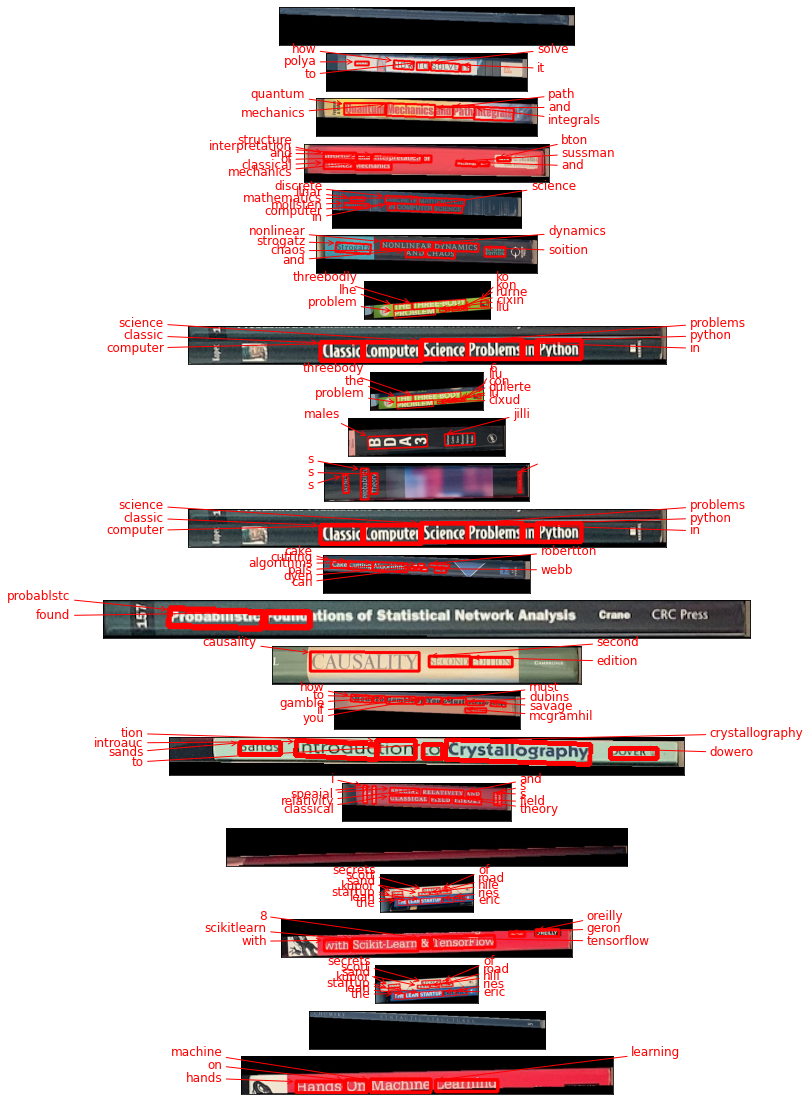

CPU times: user 1min 30s, sys: 8.82 s, total: 1min 39s
Wall time: 28 s


In [5]:
%%time
predictions = []

for image in images:
    prediction = pipeline.recognize([image])
    predictions.append(prediction[0])
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, prediction in zip(axs, images, predictions):
    drawAnnotations(image=image, predictions=prediction, ax=ax)
plt.show()

This attempt is approximately 10x faster (wall time) and qualitatively roughly as accurate (although I'll have to test much more to be sure). It still struggles with vertical book titles, namely [Probability Theory by  Jaynes](https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712)-- which will be, I suspect, trivially easy to fix with a rotation; it also missed on [BDA3](https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954).

### Third attempt: Google Cloud Platform OCR

For a final 'out-of-the-box' attempt, I'm going to go with the most out of the box attempt yet: the [OCR in the Google Cloud Vision API](https://cloud.google.com/vision/docs/ocr#vision_text_detection-python). I get 1000 images for free with the service, so I plan to use it to benchmark my other attempts. It gets [expensive quickly](https://cloud.google.com/vision/pricing).

In [6]:
# define a function to fit the plot_ocr function argument type
from google.cloud import vision
import io
import os


def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    title = []
    for _, text in enumerate(texts[1:]):
        title.append(text.description)
    return title


images = [os.path.join('../filteredbooks_CV/', file)
          for file in os.listdir('../filteredbooks_CV/')
          if str(file)[0] != '.'
         ]

CPU times: user 1.15 s, sys: 276 ms, total: 1.42 s
Wall time: 8min 21s


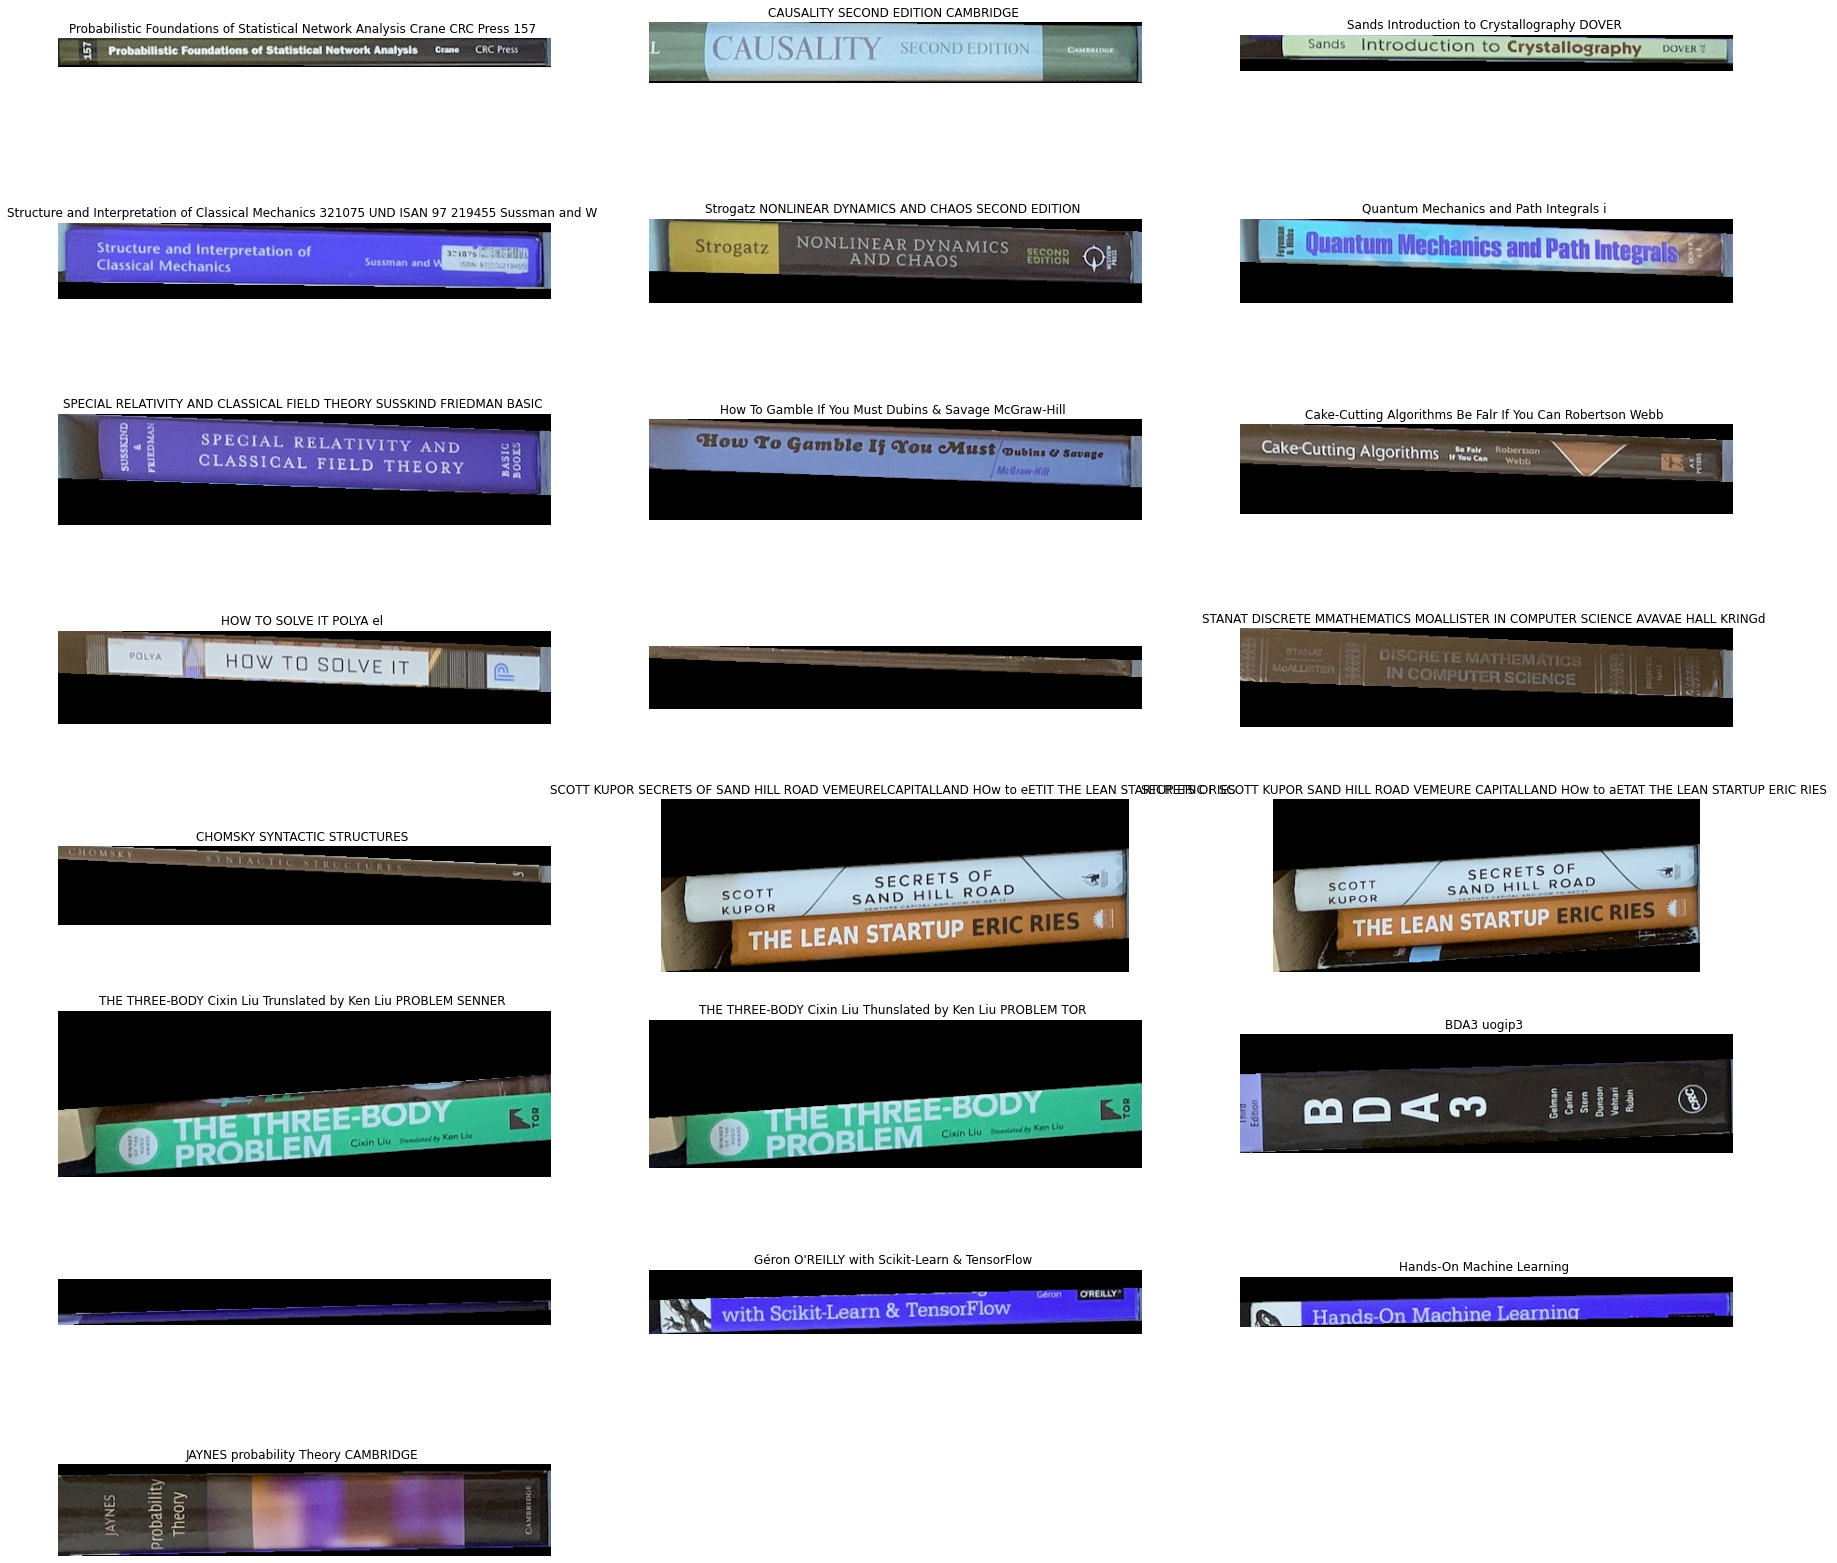

In [7]:
%%time
figure, axes = plot_ocr('../filteredbooks_CV/', 
                        detect_text,
                        path=True)

Google's TPUs gave impressive results. It had great performance on the vertical sections! It was also qualitatively on average more accurate for every title. Its speed was fast, but again, this was because I was running it on Google TPUs on the API's free tier. More quantitative speed and performance [metrics can be found here](https://github.com/faustomorales/keras-ocr).